In [59]:
import cv2
import os
import shutil

# --- Configuration for Frame Extraction ---
# ==============================================================================
# IMPORTANT: SET YOUR PATHS HERE!

# 1. The path to your dataset containing the 'Violence' and 'NonViolence' video folders.
VIDEO_DATASET_PATH = r"D:\Projects\Final Year Project\Data\Video\Real Life Violence Dataset"

# 2. The path to the NEW, EMPTY folder where the extracted frames will be saved.
FRAME_OUTPUT_PATH = r"D:\Projects\Final Year Project\Data\Video\Extracted_Frames"
# ==============================================================================

# Define the names of your class folders
CLASSES = ["ViolenceTrain", "NonViolenceTrain"]

# It's good practice to start with a clean slate
if os.path.exists(FRAME_OUTPUT_PATH):
    shutil.rmtree(FRAME_OUTPUT_PATH)
    print(f"Removed existing frames directory: {FRAME_OUTPUT_PATH}")

os.makedirs(FRAME_OUTPUT_PATH, exist_ok=True)
print(f"Created main frames directory: {FRAME_OUTPUT_PATH}")

# Loop through each class (e.g., 'Violence', then 'NonViolence')
for category in CLASSES:
    video_class_path = os.path.join(VIDEO_DATASET_PATH, category)
    frame_class_path = os.path.join(FRAME_OUTPUT_PATH, category)

    # Create the output subfolder (e.g., .../Extracted_Frames/Violence)
    os.makedirs(frame_class_path, exist_ok=True)
    
    # Check if the source video directory exists
    if not os.path.exists(video_class_path):
        print(f"[WARNING] Source directory not found: {video_class_path}. Skipping.")
        continue

    # Loop through every video file in the source directory
    for video_name in os.listdir(video_class_path):
        video_path = os.path.join(video_class_path, video_name)

        # Ensure we are processing a video file
        if not video_path.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
            continue

        print(f"[INFO] Processing video: {video_name}...")
        
        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        
        while True:
            # Read one frame from the video stream
            success, frame = cap.read()
            
            # If 'success' is False, we have reached the end of the video
            if not success:
                break
            
            # Construct the output filename
            # Example: Violence/V_7_frame_0.jpg
            base_video_name = os.path.splitext(video_name)[0]
            output_filename = f"{base_video_name}_frame_{frame_count}.jpg"
            output_filepath = os.path.join(frame_class_path, output_filename)
            
            # Save the current frame as a JPG image
            cv2.imwrite(output_filepath, frame)
            
            frame_count += 1
            
        cap.release()
        print(f"  -> Extracted {frame_count} frames.")

print("\n[SUCCESS] All videos have been processed and frames have been extracted.")

Removed existing frames directory: D:\Projects\Final Year Project\Data\Video\Extracted_Frames
Created main frames directory: D:\Projects\Final Year Project\Data\Video\Extracted_Frames
[INFO] Processing video: V_25.mp4...
  -> Extracted 129 frames.
[INFO] Processing video: V_26.mp4...
  -> Extracted 126 frames.
[INFO] Processing video: V_27.mp4...
  -> Extracted 168 frames.
[INFO] Processing video: V_28.mp4...
  -> Extracted 129 frames.
[INFO] Processing video: V_29.mp4...
  -> Extracted 108 frames.
[INFO] Processing video: V_30.mp4...
  -> Extracted 105 frames.
[INFO] Processing video: V_31.mp4...
  -> Extracted 62 frames.
[INFO] Processing video: V_32.mp4...
  -> Extracted 140 frames.
[INFO] Processing video: V_33.mp4...
  -> Extracted 143 frames.
[INFO] Processing video: V_34.mp4...
  -> Extracted 143 frames.
[INFO] Processing video: V_35.mp4...
  -> Extracted 140 frames.
[INFO] Processing video: V_36.mp4...
  -> Extracted 140 frames.
[INFO] Processing video: V_37.mp4...
  -> Extract

In [60]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# --- AI Training Configuration ---
# ==============================================================================
# This path MUST point to the folder with the EXTRACTED FRAMES from Cell 1.
DATASET_PATH = r"D:\Projects\Final Year Project\Data\Video\Extracted_Frames"

# Path where the NEW trained model will be saved.
MODEL_SAVE_PATH = r"D:\Projects\Final Year Project\violence_detection_model.h5"
# ==============================================================================

# Define image dimensions and other training parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

In [62]:
print("[INFO] Loading and preprocessing image data...")

# Initialize lists to hold the image data and corresponding labels
data = []
labels = []

# The class names must match the folder names
CLASSES = ['ViolenceTrain', 'NonViolenceTrain']

# Loop over the class folders ('Violence', 'NonViolence')
for category in CLASSES:
    path = os.path.join(DATASET_PATH, category)
    class_num = CLASSES.index(category) # Violence=0, NonViolence=1

    for img_name in os.listdir(path):
        try:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append(resized_img)
            labels.append(class_num)
        except Exception as e:
            print(f"[ERROR] Could not process image {img_name}: {e}")

# Convert to NumPy arrays and normalize
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)

# Split data into training (80%) and testing (20%) sets
(X_train, X_test, y_train, y_test) = train_test_split(
    data, labels, test_size=0.20, stratify=labels, random_state=42
)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=len(CLASSES))
y_test = to_categorical(y_test, num_classes=len(CLASSES))

print(f"\n[SUCCESS] Data loaded and preprocessed.")
print(f"Found {len(data)} total images.")
print(f"Training data shape: {X_train.shape}")

[INFO] Loading and preprocessing image data...

[SUCCESS] Data loaded and preprocessed.
Found 6197 total images.
Training data shape: (4957, 224, 224, 3)


In [63]:
print("[INFO] Building the model architecture...")

# Load the MobileNetV2 model, pre-trained on ImageNet, without its top classification layer
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create our custom classification head
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(512, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(len(CLASSES), activation="softmax")(head_model) # 2 classes: Violence, NonViolence

# Combine the base model and our custom head
model = Model(inputs=base_model.input, outputs=head_model)

# Compile the model
opt = Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

print("[INFO] Model summary:")
model.summary()

[INFO] Building the model architecture...


C:\Users\Raj\AppData\Local\Temp\ipykernel_20972\4248597689.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)))


[INFO] Model summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,914,882 (11.12 MB)

 Trainable params: 656,898 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [64]:
print("[INFO] Starting model training...")

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

print("\n[SUCCESS] Model training completed.")

[INFO] Starting model training...
Epoch 1/10


c:\Users\Raj\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1778']. Received: the structure of inputs=*
  warnings.warn(


155/155 ━━━━━━━━━━━━━━━━━━━━ 72s 422ms/step - accuracy: 0.9068 - loss: 0.2216 - val_accuracy: 0.9935 - val_loss: 0.0243
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 61s 394ms/step - accuracy: 0.9915 - loss: 0.0303 - val_accuracy: 0.9968 - val_loss: 0.0148
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 59s 382ms/step - accuracy: 0.9967 - loss: 0.0146 - val_accuracy: 0.9976 - val_loss: 0.0107
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 61s 394ms/step - accuracy: 0.9980 - loss: 0.0100 - val_accuracy: 0.9976 - val_loss: 0.0071
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 62s 401ms/step - accuracy: 0.9988 - loss: 0.0070 - val_accuracy: 0.9976 - val_loss: 0.0051
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 63s 405ms/step - accuracy: 0.9997 - loss: 0.0037 - val_accuracy: 0.9976 - val_loss: 0.0051
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 63s 404ms/step - accuracy: 0.9997 - loss: 0.0039 - val_accuracy: 0.9976 - val_loss: 0.0042
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 64s 410ms/step - accuracy: 0.9989 - loss: 0.0043 - val

[INFO] Evaluating the trained model...
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 334ms/step - accuracy: 1.0000 - loss: 7.1042e-04
[RESULTS] Test Accuracy: 100.00%
[RESULTS] Test Loss: 0.0011


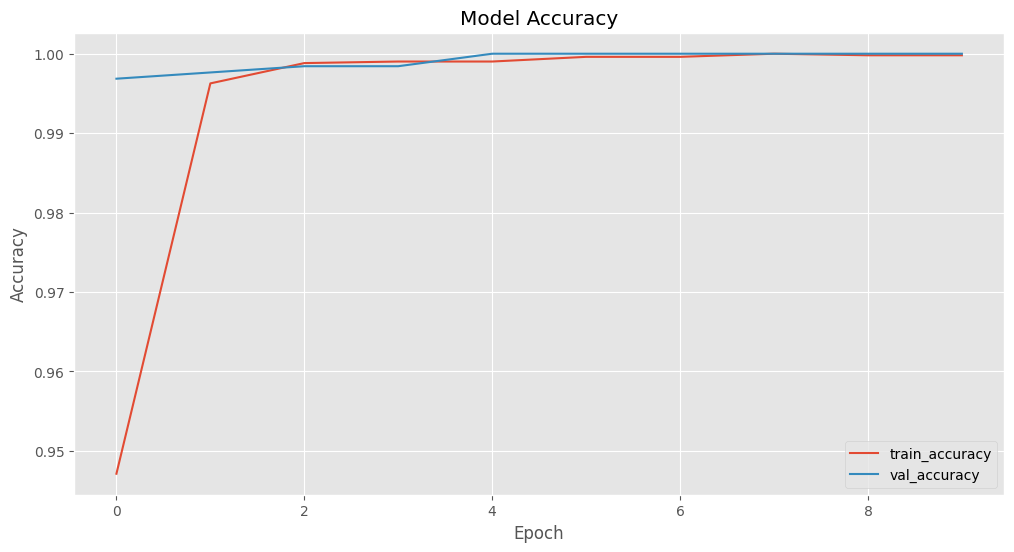

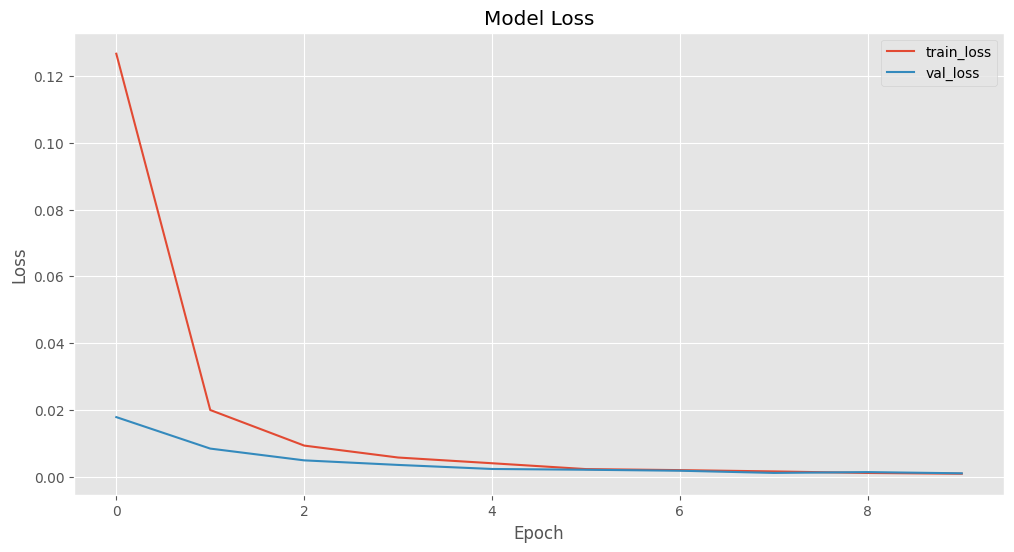


[INFO] Saving trained model to: D:\Projects\Final Year Project\violence_detection_model.h5
[SUCCESS] Model saved. This file can now be used for detection.


In [34]:
print("[INFO] Evaluating the trained model...")

# Evaluate the model on the test set
(loss, accuracy) = model.evaluate(X_test, y_test)
print(f"[RESULTS] Test Accuracy: {accuracy*100:.2f}%")
print(f"[RESULTS] Test Loss: {loss:.4f}")

# --- Plot the training history ---
plt.style.use("ggplot")
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# --- Save the trained model to disk ---
print(f"\n[INFO] Saving trained model to: {MODEL_SAVE_PATH}")
model.save(MODEL_SAVE_PATH)
print("[SUCCESS] Model saved. This file can now be used for detection.")

In [65]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import shutil

# --- Configuration ---
# ==============================================================================
# IMPORTANT: SET YOUR PATHS HERE!

# 1. Path to your TRAINED .h5 model file.
MODEL_PATH = r"D:\Projects\Final Year Project\violence_detection_model.h5"

# 2. Path to the NEW video file you want to test.
VIDEO_TO_TEST_PATH = r"D:\Projects\Final Year Project\Data\Video\Real Life Violence Dataset\ViolenceTest\V_49.mp4"

# 3. Path to a TEMPORARY folder to store frames from the test video.
#    This folder will be created and deleted automatically.
TEMP_FRAME_FOLDER = r"D:\Projects\Final Year Project\Data\Video\temp_test_frames"
# ==============================================================================

# Define image dimensions (must match the model's training dimensions)
IMG_SIZE = 224

# The classes your model was trained on. IMPORTANT: The order must be the same.
# If during training 'Violence' was 0 and 'NonViolence' was 1, keep that order.
CLASSES = ['Violence', 'NonViolence']

In [67]:
print(f"[INFO] Preparing to test video: {VIDEO_TO_TEST_PATH}")

# Create the temporary directory; starting fresh is good practice
if os.path.exists(TEMP_FRAME_FOLDER):
    shutil.rmtree(TEMP_FRAME_FOLDER)
os.makedirs(TEMP_FRAME_FOLDER)

print(f"[INFO] Created temporary frame folder: {TEMP_FRAME_FOLDER}")

# --- Frame Extraction ---
cap = cv2.VideoCapture(VIDEO_TO_TEST_PATH)
frame_count = 0

while True:
    success, frame = cap.read()
    if not success:
        break
    
    # Save frame as a JPG file
    frame_filename = os.path.join(TEMP_FRAME_FOLDER, f"frame_{frame_count}.jpg")
    cv2.imwrite(frame_filename, frame)
    frame_count += 1

cap.release()
print(f"[SUCCESS] Extracted {frame_count} frames from the test video.")

[INFO] Preparing to test video: D:\Projects\Final Year Project\Data\Video\Real Life Violence Dataset\ViolenceTest\V_49.mp4
[INFO] Created temporary frame folder: D:\Projects\Final Year Project\Data\Video\temp_test_frames
[SUCCESS] Extracted 120 frames from the test video.


In [68]:
print(f"[INFO] Loading trained model from: {MODEL_PATH}")

# --- Load the Model ---
try:
    model = load_model(MODEL_PATH)
    print("[SUCCESS] Model loaded.")
except Exception as e:
    print(f"[FATAL ERROR] Could not load model. Error: {e}")
    # Stop the script if the model can't be loaded
    model = None

if model:
    # --- Prediction on Frames ---
    print("\n[INFO] Starting prediction on extracted frames...")
    
    # Get the list of frames to test
    test_frame_names = sorted(os.listdir(TEMP_FRAME_FOLDER), key=lambda x: int(x.split('_')[1].split('.')[0]))
    
    violence_predictions = 0
    nonviolence_predictions = 0
    
    for frame_name in test_frame_names:
        # Construct the full path to the frame
        frame_path = os.path.join(TEMP_FRAME_FOLDER, frame_name)
        
        # --- Preprocess the Frame ---
        # 1. Read the image
        img = cv2.imread(frame_path)
        # 2. Resize to the model's expected input size
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        # 3. Convert to array and normalize pixel values
        img_array = img_to_array(img_resized) / 255.0
        # 4. Add a "batch" dimension to match the model's input shape
        img_expanded = np.expand_dims(img_array, axis=0)
        
        # --- Make a Prediction ---
        prediction = model.predict(img_expanded, verbose=0)
        
        # Get the index of the highest probability
        predicted_class_index = np.argmax(prediction[0])
        confidence = np.max(prediction[0])
        
        # Get the label name from the index
        predicted_class_label = CLASSES[predicted_class_index]
        
        print(f"  -> Frame: {frame_name} | Prediction: {predicted_class_label} | Confidence: {confidence:.2%}")
        
        # Tally the results
        if predicted_class_label == 'Violence':
            violence_predictions += 1
        else:
            nonviolence_predictions += 1
            
    print("\n[INFO] Prediction complete.")
    
    # --- Summarize the Results ---
    total_frames = len(test_frame_names)
    violence_percentage = (violence_predictions / total_frames) * 100
    nonviolence_percentage = (nonviolence_predictions / total_frames) * 100
    
    print("\n--- Video Test Summary ---")
    print(f"Total Frames Analyzed: {total_frames}")
    print(f"Frames classified as 'Violence': {violence_predictions} ({violence_percentage:.2f}%)")
    print(f"Frames classified as 'NonViolence': {nonviolence_predictions} ({nonviolence_percentage:.2f}%)")
    
    # Make a final judgment based on a simple threshold
    if violence_percentage > 25: # Example threshold: if more than 25% of frames are violent
        print("\n[CONCLUSION] The model suggests that the video likely contains violence.")
    else:
        print("\n[CONCLUSION] The model suggests that the video likely does not contain violence.")

[INFO] Loading trained model from: D:\Projects\Final Year Project\violence_detection_model.h5


[SUCCESS] Model loaded.

[INFO] Starting prediction on extracted frames...
  -> Frame: frame_0.jpg | Prediction: Violence | Confidence: 100.00%
  -> Frame: frame_1.jpg | Prediction: Violence | Confidence: 100.00%
  -> Frame: frame_2.jpg | Prediction: Violence | Confidence: 100.00%
  -> Frame: frame_3.jpg | Prediction: Violence | Confidence: 100.00%
  -> Frame: frame_4.jpg | Prediction: Violence | Confidence: 100.00%
  -> Frame: frame_5.jpg | Prediction: Violence | Confidence: 100.00%
  -> Frame: frame_6.jpg | Prediction: Violence | Confidence: 100.00%
  -> Frame: frame_7.jpg | Prediction: Violence | Confidence: 100.00%
  -> Frame: frame_8.jpg | Prediction: Violence | Confidence: 100.00%
  -> Frame: frame_9.jpg | Prediction: Violence | Confidence: 100.00%
  -> Frame: frame_10.jpg | Prediction: Violence | Confidence: 100.00%
  -> Frame: frame_11.jpg | Prediction: Violence | Confidence: 100.00%
  -> Frame: frame_12.jpg | Prediction: Violence | Confidence: 100.00%
  -> Frame: frame_13.jpg 

In [57]:
print("\n[INFO] Cleaning up temporary files...")
try:
    shutil.rmtree(TEMP_FRAME_FOLDER)
    print("[SUCCESS] Temporary frame folder deleted.")
except Exception as e:
    print(f"[ERROR] Could not delete temporary folder. You may need to delete it manually. Error: {e}")


[INFO] Cleaning up temporary files...
[SUCCESS] Temporary frame folder deleted.
